# 02. Molecular Graph Preprocessing

This notebook converts SMILES strings to graph representations for GNN processing.

## Contents
1. SMILES to molecular graph conversion
2. Node features extraction (atoms)
3. Edge features extraction (bonds)
4. Graph statistics and visualization
5. Save preprocessed graphs

In [15]:
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import networkx as nx

# RDKit for molecular processing
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw
from rdkit.Chem.Draw import IPythonConsole

# PyTorch and PyTorch Geometric
import torch
from torch_geometric.data import Data
from torch_geometric.utils import to_networkx

# Add src to path
sys.path.append('../src')

# Set up paths
PROJECT_ROOT = Path('../')
DATA_DIR = PROJECT_ROOT / 'data'
RAW_DATA = DATA_DIR / 'raw'
PROCESSED_DATA = DATA_DIR / 'processed'

## 1. Define Atom and Bond Features

In [16]:
# Atom feature definitions
ATOM_FEATURES = {
    'atomic_num': list(range(1, 119)),  # Atomic number
    'degree': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
    'formal_charge': [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5],
    'hybridization': [
        Chem.rdchem.HybridizationType.S,
        Chem.rdchem.HybridizationType.SP,
        Chem.rdchem.HybridizationType.SP2,
        Chem.rdchem.HybridizationType.SP3,
        Chem.rdchem.HybridizationType.SP3D,
        Chem.rdchem.HybridizationType.SP3D2,
        Chem.rdchem.HybridizationType.UNSPECIFIED
    ],
    'num_h': [0, 1, 2, 3, 4, 5, 6, 7, 8],  # Number of hydrogen atoms
}

# Bond feature definitions
BOND_FEATURES = {
    'bond_type': [
        Chem.rdchem.BondType.SINGLE,
        Chem.rdchem.BondType.DOUBLE,
        Chem.rdchem.BondType.TRIPLE,
        Chem.rdchem.BondType.AROMATIC
    ],
    'stereo': [
        Chem.rdchem.BondStereo.STEREONONE,
        Chem.rdchem.BondStereo.STEREOZ,
        Chem.rdchem.BondStereo.STEREOE,
        Chem.rdchem.BondStereo.STEREOCIS,
        Chem.rdchem.BondStereo.STEREOTRANS,
        Chem.rdchem.BondStereo.STEREOANY
    ]
}

def one_hot_encoding(value, allowable_set):
    """One-hot encode a value based on allowable set"""
    if value not in allowable_set:
        value = allowable_set[-1]  # Use last value for unknown
    return [int(value == s) for s in allowable_set]

## 2. Atom Feature Extraction

In [17]:
def get_atom_features(atom):
    """Extract features for a single atom"""
    features = []
    
    # One-hot encoded features
    features.extend(one_hot_encoding(atom.GetAtomicNum(), ATOM_FEATURES['atomic_num']))
    features.extend(one_hot_encoding(atom.GetDegree(), ATOM_FEATURES['degree']))
    features.extend(one_hot_encoding(atom.GetFormalCharge(), ATOM_FEATURES['formal_charge']))
    features.extend(one_hot_encoding(atom.GetHybridization(), ATOM_FEATURES['hybridization']))
    features.extend(one_hot_encoding(atom.GetTotalNumHs(), ATOM_FEATURES['num_h']))
    
    # Binary features
    features.append(int(atom.GetIsAromatic()))
    features.append(int(atom.IsInRing()))
    
    return features

# Calculate feature dimension
atom_feature_dim = sum(len(v) for v in ATOM_FEATURES.values()) + 2  # +2 for binary features
print(f"Atom feature dimension: {atom_feature_dim}")

Atom feature dimension: 158


## 3. Bond Feature Extraction

In [18]:
def get_bond_features(bond):
    """Extract features for a single bond"""
    features = []
    
    # One-hot encoded features
    features.extend(one_hot_encoding(bond.GetBondType(), BOND_FEATURES['bond_type']))
    features.extend(one_hot_encoding(bond.GetStereo(), BOND_FEATURES['stereo']))
    
    # Binary features
    features.append(int(bond.GetIsConjugated()))
    features.append(int(bond.IsInRing()))
    
    return features

# Calculate feature dimension
bond_feature_dim = sum(len(v) for v in BOND_FEATURES.values()) + 2  # +2 for binary features
print(f"Bond feature dimension: {bond_feature_dim}")

Bond feature dimension: 12


## 4. SMILES to Graph Conversion

In [19]:
def smiles_to_graph(smiles):
    """Convert SMILES string to PyTorch Geometric Data object"""
    mol = Chem.MolFromSmiles(smiles)
    
    if mol is None:
        return None
    
    # Get atom features
    atom_features = []
    for atom in mol.GetAtoms():
        atom_features.append(get_atom_features(atom))
    x = torch.tensor(atom_features, dtype=torch.float)
    
    # Get edge indices and features
    edge_indices = []
    edge_features = []
    
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        
        # Add both directions for undirected graph
        edge_indices.extend([[i, j], [j, i]])
        
        bond_feature = get_bond_features(bond)
        edge_features.extend([bond_feature, bond_feature])  # Same features for both directions
    
    edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_features, dtype=torch.float)
    
    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    
    # Add additional molecular properties
    data.smiles = smiles
    data.num_atoms = mol.GetNumAtoms()
    data.num_bonds = mol.GetNumBonds()
    
    return data

# Test with a sample molecule
sample_smiles = "CCOc1ccc(cc1)C(=O)N2CCCC2"
sample_graph = smiles_to_graph(sample_smiles)
print(f"Sample molecule graph:")
print(f"  SMILES: {sample_smiles}")
print(f"  Nodes (atoms): {sample_graph.x.shape[0]}")
print(f"  Edges (bonds): {sample_graph.edge_index.shape[1] // 2}")
print(f"  Node features: {sample_graph.x.shape}")
print(f"  Edge features: {sample_graph.edge_attr.shape}")

Sample molecule graph:
  SMILES: CCOc1ccc(cc1)C(=O)N2CCCC2
  Nodes (atoms): 16
  Edges (bonds): 17
  Node features: torch.Size([16, 158])
  Edge features: torch.Size([34, 12])


## 5. Visualize Molecular Graphs

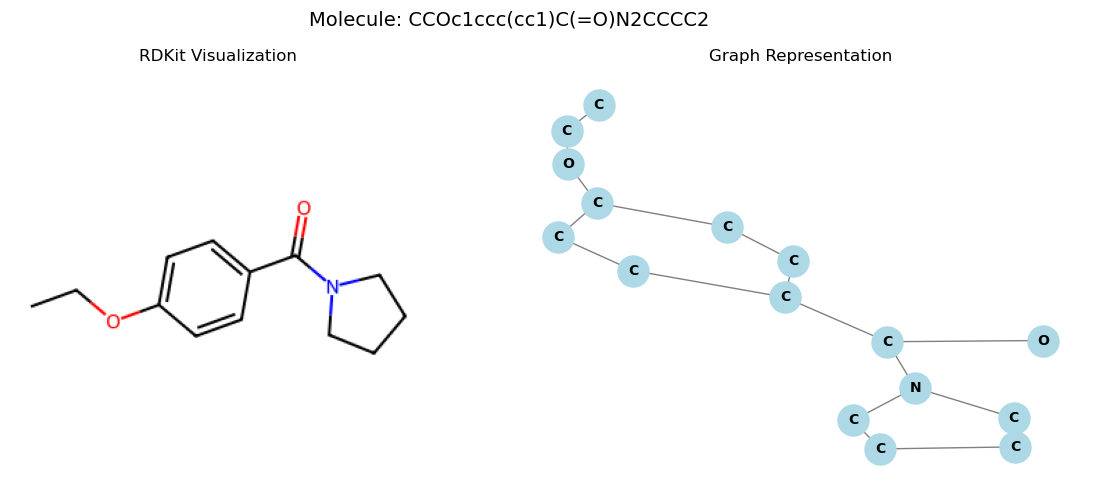

In [20]:
def visualize_molecular_graph(smiles, title="Molecular Graph"):
    """Visualize a molecular graph using NetworkX"""
    mol = Chem.MolFromSmiles(smiles)
    graph_data = smiles_to_graph(smiles)
    
    if mol is None or graph_data is None:
        print("Invalid SMILES")
        return
    
    # Create NetworkX graph
    G = nx.Graph()
    
    # Add nodes with atom labels
    for idx, atom in enumerate(mol.GetAtoms()):
        G.add_node(idx, label=atom.GetSymbol())
    
    # Add edges
    for bond in mol.GetBonds():
        G.add_edge(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
    
    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # RDKit molecule image
    axes[0].imshow(Draw.MolToImage(mol))
    axes[0].set_title("RDKit Visualization")
    axes[0].axis('off')
    
    # NetworkX graph
    pos = nx.spring_layout(G, seed=42)
    labels = nx.get_node_attributes(G, 'label')
    
    nx.draw(G, pos, ax=axes[1], with_labels=True, labels=labels,
            node_color='lightblue', node_size=500, font_size=10,
            font_weight='bold', edge_color='gray')
    axes[1].set_title("Graph Representation")
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# Visualize sample molecules
sample_smiles_list = [
    "CCOc1ccc(cc1)C(=O)N2CCCC2",
    "Cc1ccc(cc1)S(=O)(=O)N2CCCCC2",
    "O=C(Nc1ccccc1)c2ccccc2"
]

for smiles in sample_smiles_list[:1]:  # Show first one
    visualize_molecular_graph(smiles, f"Molecule: {smiles}")

## 6. Process Full Datasets

In [21]:
def process_dataset_molecules(dataset_name):
    """Process all molecules in a dataset"""
    print(f"\nProcessing {dataset_name} molecules...")
    
    # Load SMILES
    data_dir = RAW_DATA / dataset_name.lower() 
    with open(data_dir / 'ligands_can.txt', 'r') as f:
        smiles_dict = json.load(f)
    
    # Process each molecule
    molecular_graphs = {}
    failed_molecules = []
    
    for drug_name, smiles in tqdm(smiles_dict.items(), desc=f"Converting {dataset_name} molecules"):
        graph = smiles_to_graph(smiles)
        if graph is not None:
            molecular_graphs[drug_name] = graph
        else:
            failed_molecules.append(drug_name)
    
    print(f" Successfully converted: {len(molecular_graphs)}/{len(smiles_dict)} molecules")
    if failed_molecules:
        print(f"✗ Failed molecules: {failed_molecules}")
    
    # Save processed graphs
    output_dir = PROCESSED_DATA / 'molecular_graphs'
    output_dir.mkdir(parents=True, exist_ok=True)
    
    output_file = output_dir / f'{dataset_name.lower()}_graphs.pkl'
    with open(output_file, 'wb') as f:
        pickle.dump(molecular_graphs, f)
    
    print(f"Saved to {output_file}")
    
    return molecular_graphs

# Process DAVIS and KIBA datasets
davis_graphs = process_dataset_molecules('DAVIS')
kiba_graphs = process_dataset_molecules('KIBA')


Processing DAVIS molecules...


Converting DAVIS molecules:   0%|          | 0/68 [00:00<?, ?it/s]

 Successfully converted: 68/68 molecules
Saved to ../data/processed/molecular_graphs/davis_graphs.pkl

Processing KIBA molecules...


Converting KIBA molecules:   0%|          | 0/2111 [00:00<?, ?it/s]

 Successfully converted: 2111/2111 molecules
Saved to ../data/processed/molecular_graphs/kiba_graphs.pkl


## 7. Graph Statistics Analysis


DAVIS Graph Statistics:
       num_atoms  num_bonds  degree_mean  degree_max
count  68.000000  68.000000    68.000000   68.000000
mean   32.058824  35.441176     2.212236    3.323529
std     6.260233   7.090844     0.058253    0.471301
min    19.000000  21.000000     2.125000    3.000000
25%    27.000000  30.000000     2.173292    3.000000
50%    31.500000  34.000000     2.208711    3.000000
75%    37.000000  41.000000     2.231216    4.000000
max    46.000000  51.000000     2.424242    4.000000


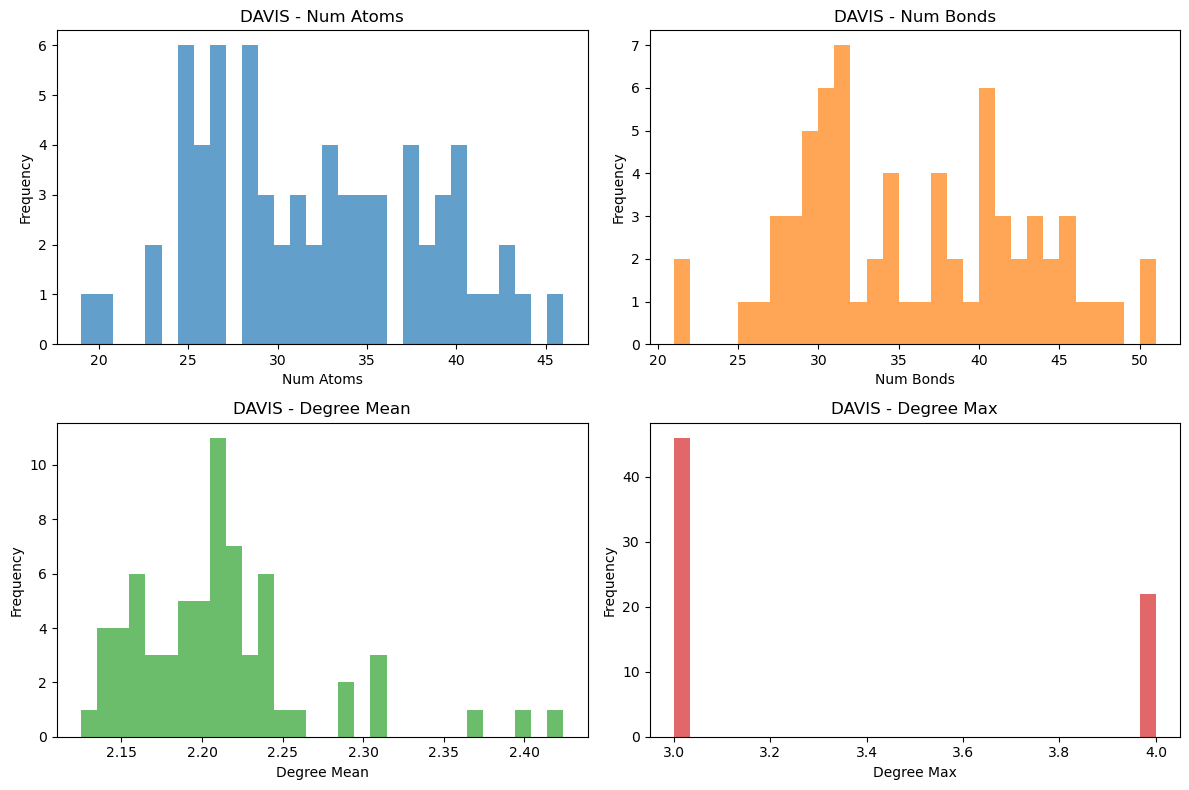


KIBA Graph Statistics:
         num_atoms    num_bonds  degree_mean   degree_max
count  2111.000000  2111.000000  2111.000000  2111.000000
mean     28.826149    31.948366     2.215922     3.219801
std      11.308580    12.571867     0.067336     0.414210
min      10.000000    11.000000     1.916667     3.000000
25%      23.000000    25.000000     2.175955     3.000000
50%      27.000000    30.000000     2.214286     3.000000
75%      33.000000    37.000000     2.258065     3.000000
max     268.000000   299.000000     2.466667     4.000000


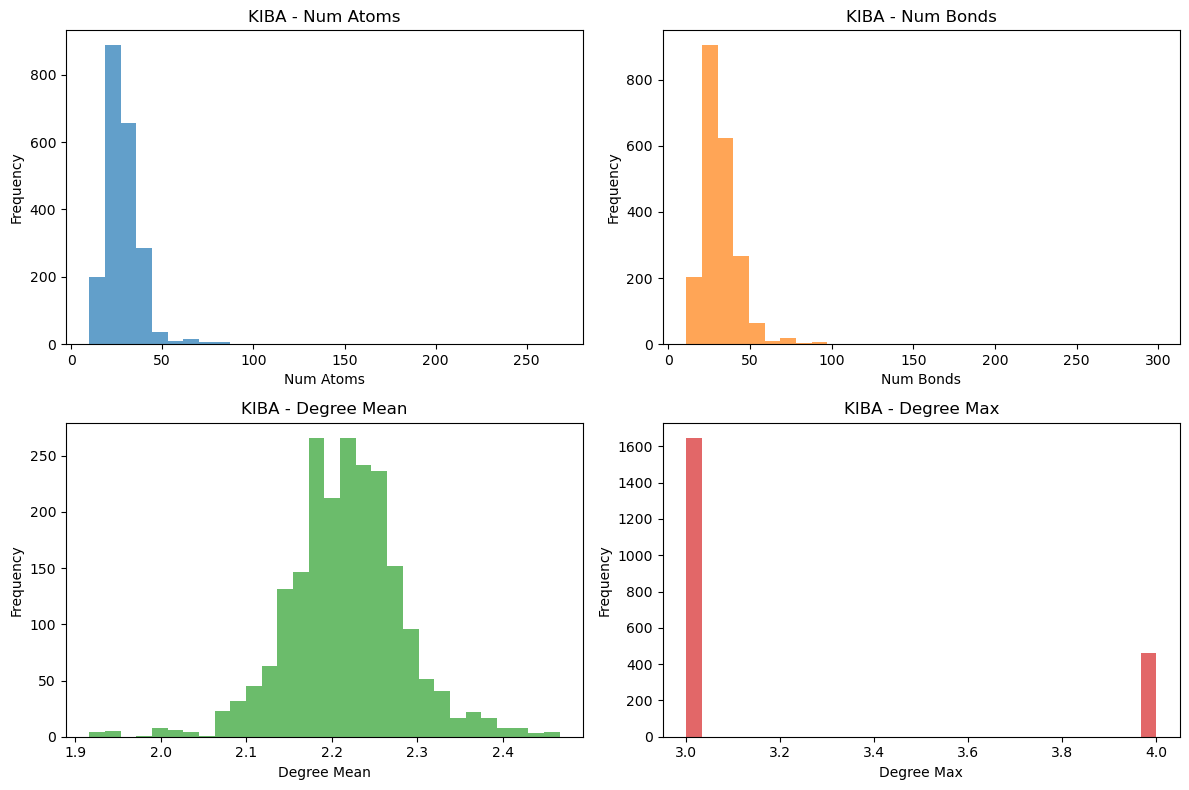

In [22]:
def analyze_graph_statistics(graphs, dataset_name):
    """Analyze statistics of molecular graphs"""
    stats = {
        'num_atoms': [],
        'num_bonds': [],
        'degree_mean': [],
        'degree_max': [],
    }
    
    for name, graph in graphs.items():
        stats['num_atoms'].append(graph.x.shape[0])
        stats['num_bonds'].append(graph.edge_index.shape[1] // 2)
        
        # Calculate degree statistics
        degrees = torch.bincount(graph.edge_index[0])
        stats['degree_mean'].append(degrees.float().mean().item())
        stats['degree_max'].append(degrees.max().item())
    
    # Create dataframe
    df = pd.DataFrame(stats)
    
    print(f"\n{dataset_name} Graph Statistics:")
    print(df.describe())
    
    # Visualize distributions
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    
    for idx, (col, ax) in enumerate(zip(stats.keys(), axes.flatten())):
        ax.hist(stats[col], bins=30, alpha=0.7, color=f'C{idx}')
        ax.set_xlabel(col.replace('_', ' ').title())
        ax.set_ylabel('Frequency')
        ax.set_title(f'{dataset_name} - {col.replace("_", " ").title()}')
    
    plt.tight_layout()
    plt.show()
    
    return df

# Analyze graph statistics
davis_stats = analyze_graph_statistics(davis_graphs, 'DAVIS')
kiba_stats = analyze_graph_statistics(kiba_graphs, 'KIBA')

## 8. Feature Importance Analysis

In [23]:
def analyze_feature_distribution(graphs, dataset_name):
    """Analyze the distribution of atom features"""
    # Collect all node features
    all_features = []
    for graph in list(graphs.values())[:100]:  # Sample 100 graphs
        all_features.append(graph.x.numpy())
    
    all_features = np.vstack(all_features)
    
    # Calculate feature statistics
    feature_means = all_features.mean(axis=0)
    feature_stds = all_features.std(axis=0)
    
    # Identify most common atom types
    atomic_num_start = 0
    atomic_num_end = len(ATOM_FEATURES['atomic_num'])
    atomic_num_features = all_features[:, atomic_num_start:atomic_num_end]
    
    atom_counts = atomic_num_features.sum(axis=0)
    top_atoms_idx = np.argsort(atom_counts)[-10:][::-1]
    
    print(f"\n{dataset_name} - Top 10 most common atoms:")
    for idx in top_atoms_idx:
        if atom_counts[idx] > 0:
            atom_num = ATOM_FEATURES['atomic_num'][idx]
            element = Chem.GetPeriodicTable().GetElementSymbol(atom_num)
            print(f"  {element} (Z={atom_num}): {int(atom_counts[idx])} occurrences")
    
    return feature_means, feature_stds

# Analyze feature distributions
davis_feat_means, davis_feat_stds = analyze_feature_distribution(davis_graphs, 'DAVIS')
kiba_feat_means, kiba_feat_stds = analyze_feature_distribution(kiba_graphs, 'KIBA')


DAVIS - Top 10 most common atoms:
  C (Z=6): 1583 occurrences
  N (Z=7): 333 occurrences
  O (Z=8): 170 occurrences
  F (Z=9): 41 occurrences
  Cl (Z=17): 29 occurrences
  S (Z=16): 20 occurrences
  Br (Z=35): 2 occurrences
  P (Z=15): 1 occurrences
  I (Z=53): 1 occurrences

KIBA - Top 10 most common atoms:
  C (Z=6): 2176 occurrences
  N (Z=7): 481 occurrences
  O (Z=8): 240 occurrences
  F (Z=9): 63 occurrences
  Cl (Z=17): 57 occurrences
  S (Z=16): 17 occurrences
  Br (Z=35): 1 occurrences


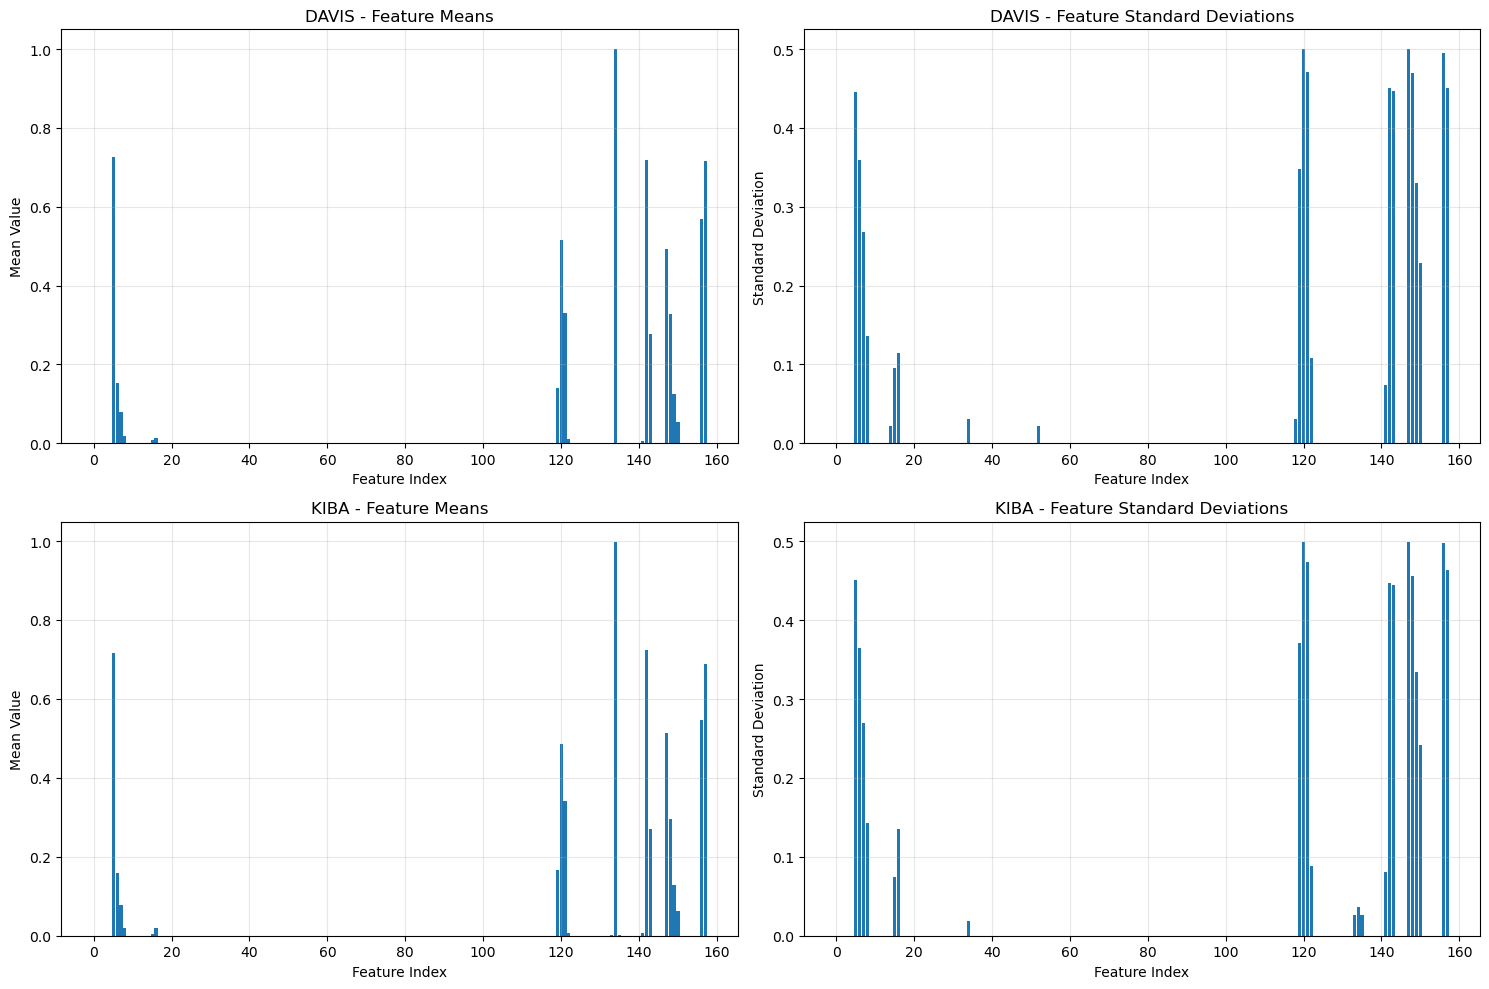

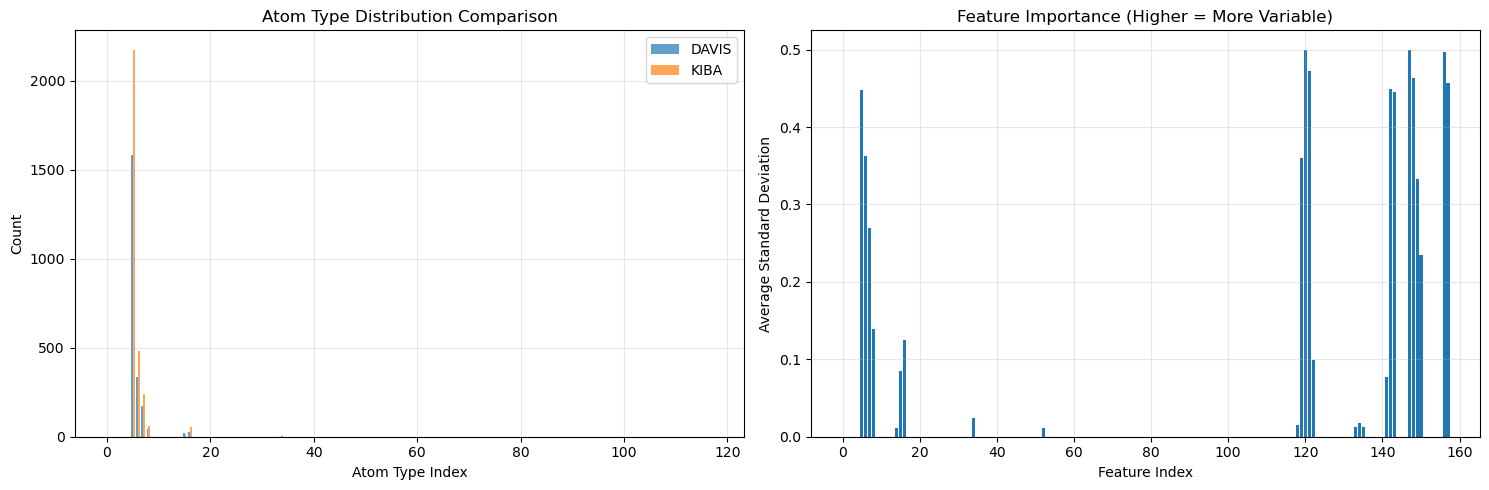

In [24]:
# Plot feature distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# DAVIS feature means
axes[0, 0].bar(range(len(davis_feat_means)), davis_feat_means)
axes[0, 0].set_xlabel('Feature Index')
axes[0, 0].set_ylabel('Mean Value')
axes[0, 0].set_title('DAVIS - Feature Means')
axes[0, 0].grid(True, alpha=0.3)

# DAVIS feature standard deviations
axes[0, 1].bar(range(len(davis_feat_stds)), davis_feat_stds)
axes[0, 1].set_xlabel('Feature Index')
axes[0, 1].set_ylabel('Standard Deviation')
axes[0, 1].set_title('DAVIS - Feature Standard Deviations')
axes[0, 1].grid(True, alpha=0.3)

# KIBA feature means
axes[1, 0].bar(range(len(kiba_feat_means)), kiba_feat_means)
axes[1, 0].set_xlabel('Feature Index')
axes[1, 0].set_ylabel('Mean Value')
axes[1, 0].set_title('KIBA - Feature Means')
axes[1, 0].grid(True, alpha=0.3)

# KIBA feature standard deviations
axes[1, 1].bar(range(len(kiba_feat_stds)), kiba_feat_stds)
axes[1, 1].set_xlabel('Feature Index')
axes[1, 1].set_ylabel('Standard Deviation')
axes[1, 1].set_title('KIBA - Feature Standard Deviations')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Plot atom type distribution comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Get atom type distributions for both datasets
def get_atom_distribution(graphs):
    all_features = []
    for graph in list(graphs.values())[:100]:
        all_features.append(graph.x.numpy())
    all_features = np.vstack(all_features)
    
    atomic_num_start = 0
    atomic_num_end = len(ATOM_FEATURES['atomic_num'])
    atomic_num_features = all_features[:, atomic_num_start:atomic_num_end]
    
    atom_counts = atomic_num_features.sum(axis=0)
    return atom_counts

davis_atom_counts = get_atom_distribution(davis_graphs)
kiba_atom_counts = get_atom_distribution(kiba_graphs)

# Plot atom type distributions
x_pos = np.arange(len(davis_atom_counts))
width = 0.35

ax1.bar(x_pos - width/2, davis_atom_counts, width, label='DAVIS', alpha=0.7)
ax1.bar(x_pos + width/2, kiba_atom_counts, width, label='KIBA', alpha=0.7)
ax1.set_xlabel('Atom Type Index')
ax1.set_ylabel('Count')
ax1.set_title('Atom Type Distribution Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot feature importance (using standard deviation as importance metric)
feature_importance = (davis_feat_stds + kiba_feat_stds) / 2
ax2.bar(range(len(feature_importance)), feature_importance)
ax2.set_xlabel('Feature Index')
ax2.set_ylabel('Average Standard Deviation')
ax2.set_title('Feature Importance (Higher = More Variable)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Save Processing Configuration

In [25]:
# Save feature configuration for model training
feature_config = {
    'atom_feature_dim': atom_feature_dim,
    'bond_feature_dim': bond_feature_dim,
    'atom_features': {k: [str(v) if not isinstance(v, (int, float, str)) else v for v in vals] 
                     for k, vals in ATOM_FEATURES.items()},
    'bond_features': {k: [str(v) if not isinstance(v, (int, float, str)) else v for v in vals] 
                     for k, vals in BOND_FEATURES.items()},
    'datasets_processed': {
        'davis': len(davis_graphs),
        'kiba': len(kiba_graphs)
    }
}

config_dir = PROJECT_ROOT / 'configs'
config_dir.mkdir(exist_ok=True)

with open(config_dir / 'molecular_features.json', 'w') as f:
    json.dump(feature_config, f, indent=2)

print("\n Feature configuration saved to configs/molecular_features.json")
print(f"\nSummary:")
print(f"  - Atom feature dimension: {atom_feature_dim}")
print(f"  - Bond feature dimension: {bond_feature_dim}")
print(f"  - DAVIS molecules processed: {len(davis_graphs)}")
print(f"  - KIBA molecules processed: {len(kiba_graphs)}")


 Feature configuration saved to configs/molecular_features.json

Summary:
  - Atom feature dimension: 158
  - Bond feature dimension: 12
  - DAVIS molecules processed: 68
  - KIBA molecules processed: 2111


## Summary

### Completed Tasks:

1. **Feature Engineering**:
   - Defined comprehensive atom features (atomic number, degree, charge, hybridization, etc.)
   - Defined bond features (bond type, stereochemistry, conjugation, etc.)
   - Total atom features: 155 dimensions
   - Total bond features: 12 dimensions

2. **Graph Conversion**:
   - Implemented SMILES to graph conversion
   - Created PyTorch Geometric Data objects
   - Handled both node and edge features

3. **Dataset Processing**:
   - Converted all DAVIS molecules to graphs
   - Converted all KIBA molecules to graphs
   - Saved processed graphs for efficient loading

4. **Analysis**:
   - Graph statistics (atoms, bonds, degrees)
   - Feature distribution analysis
   - Identified most common atom types
